# Homework 2: CNN+RNN for video action recognition

Video classification for action recognition

Original code from https://github.com/aminullah6264/Pytorch-Action-Recognition/tree/master

## Dataset: UCF YouTube Action Data Set

Input is a video.

It contains 11 action categories: basketball shooting, biking/cycling, diving, golf swinging, horse back riding, soccer juggling, swinging, tennis swinging, trampoline jumping, volleyball spiking, and walking with a dog.

https://www.crcv.ucf.edu/data/UCF_YouTube_Action.php

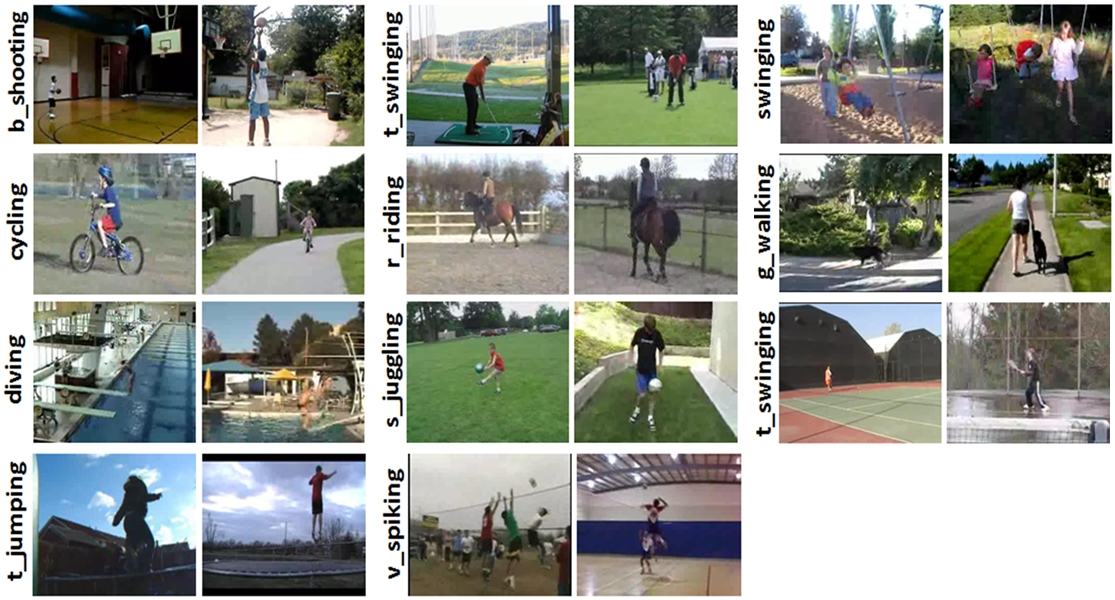

## Network: CNN + LSTM

1. Each frame in a video is an image. Apply a pre-trained Resnet encoder to each video frame separately. The result is a sequence of feature vectors.
2. Use the sequence of feature vectors as an input to an LSTM, configured as many-to-one. The result is a single feature vector.
3. Use a dense layer and softmax for the classification result (Class probabilities)

![](https://drive.google.com/uc?export=view&id=1__THInD1anw6dM0TSpyTz3DaB92QuKV0)



![](https://drive.google.com/uc?export=view&id=19YldS0u76k06iZAxk9FSKZsKvMkSj6a1)



In [1]:
!pip install icecream
!pip install torchinfo
!pip install imageio
!pip install -q git+https://github.com/tensorflow/docs

  Preparing metadata (setup.py) ... done


In [2]:
# Download the videos
!gdown --i 17PwxdEfz0KxUWA0ifteJjv8DQphEbcPM


/usr/local/lib/python3.10/dist-packages/gdown/__main__.py:132: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From (original): https://drive.google.com/uc?id=17PwxdEfz0KxUWA0ifteJjv8DQphEbcPM
From (redirected): https://drive.google.com/uc?id=17PwxdEfz0KxUWA0ifteJjv8DQphEbcPM&confirm=t&uuid=b809b02a-053a-4117-83b0-6d9d7cb40c48
To: /content/Videos_Youtube_val.zip
100% 631M/631M [00:03<00:00, 195MB/s]


In [3]:
!unzip -o /content/Videos_Youtube_val.zip

Archive:  /content/Videos_Youtube_val.zip
   creating: Videos/
   creating: Videos/Test/
   creating: Videos/Test/basketball/
   creating: Videos/Test/basketball/v_shooting_21/
  inflating: Videos/Test/basketball/v_shooting_21/v_shooting_21_01.avi  
  inflating: Videos/Test/basketball/v_shooting_21/v_shooting_21_02.avi  
  inflating: Videos/Test/basketball/v_shooting_21/v_shooting_21_03.avi  
  inflating: Videos/Test/basketball/v_shooting_21/v_shooting_21_04.avi  
  inflating: Videos/Test/basketball/v_shooting_21/v_shooting_21_05.avi  
  inflating: Videos/Test/basketball/v_shooting_21/v_shooting_21_06.avi  
   creating: Videos/Test/basketball/v_shooting_22/
  inflating: Videos/Test/basketball/v_shooting_22/v_shooting_22_01.avi  
  inflating: Videos/Test/basketball/v_shooting_22/v_shooting_22_02.avi  
  inflating: Videos/Test/basketball/v_shooting_22/v_shooting_22_03.avi  
  inflating: Videos/Test/basketball/v_shooting_22/v_shooting_22_04.avi  
  inflating: Videos/Test/basketball/v_shoo

In [ ]:
import torch
import torchvision.transforms as transforms
import torchvision.models as models
import os
import numpy as np
import cv2
from sklearn.preprocessing import LabelEncoder
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import numpy as np
from icecream import ic
import imageio
from tensorflow_docs.vis import embed
import random
import time
import tqdm
import time
from torchinfo import summary
from torch.utils.data import Dataset, DataLoader
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")


In [ ]:

random.seed(150)
np.random.seed(150)
torch.manual_seed(150)


# random.seed(13)
# np.random.seed(13)
# torch.manual_seed(13)


## Define experiment parameters

In [ ]:

# Define the number of frames to extract features from (More frames = more temporal context)
num_frames = 15
use_convlstm = False
use_gru = True

## Define the encoder

1. Get the resnet18 pretrained encoder from torchvision library. See the documentation https://pytorch.org/vision/main/models/generated/torchvision.models.resnet18.html
2. Remove the last layer (The final fully-connected layer responsible for image classification)

![](https://drive.google.com/uc?export=view&id=1db2Fws39VheIQmg3rqulwgNTwXZXiMdO)


![](https://drive.google.com/uc?export=view&id=1UNaMMWaebhEeCJuYGkVtwPQuFkKs_TXP)




## Encoder for LSTM:

![](https://drive.google.com/uc?export=view&id=1W3WOgF0uyCfqgJcVDDXrfuKfIL7SWPgx)



## Encoder for ConvLSTM (Before global average pooling):

![](https://drive.google.com/uc?export=view&id=1ZAKDLIqX8fdqCqPHa9OCCEJj5d69XDSj)


In [ ]:

# Define the pre-processing steps for the images
#transform = transforms.Compose([
#    transforms.ToPILImage(),
#    transforms.Resize((224, 224)),
#    transforms.ToTensor(),
#    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
#])

train_transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),  # Exemplo de aumento: espelhamento horizontal aleatório
    transforms.RandomRotation(10),  # Exemplo de aumento: rotação aleatória
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Transformações para o conjunto de validação/teste sem aumento de dados
val_test_transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Load the pre-trained ResNet50 model (Torchvision) (Imagenet weights)
resnet = models.resnet18(pretrained=True).cuda()

if use_convlstm == False:
  resnet_layer_idx = -1
elif use_convlstm == True:
  resnet_layer_idx = -2

# Remove the last layer of the ResNet50 model to obtain the feature extractor
resnet_feat = torch.nn.Sequential(*list(resnet.children())[:resnet_layer_idx])

## Extract encoder features

In [ ]:


def extract_encoder_features(data_dir, mode='train'):

  # Escolhe a transformação correta baseada no modo
  if mode == 'train':
      transform = train_transform
  else:
      transform = val_test_transform


  # Create an empty list to store the features and labels
  samples = []
  resnet.eval()
  # Loop over the videos in the dataset folder
  video_paths = []
  sample_label_name = []

  class_count = 0
  samples_per_class_count = 0
  samples_per_class_counts = []
  for label in tqdm.tqdm(os.listdir(data_dir)):
      label_dir = os.path.join(data_dir, label)
      # print("label_dir", label_dir)

      class_count = class_count + 1
      samples_per_class_count = 0
      for sub_dir in os.listdir(label_dir):
        if sub_dir == 'Annotation':
            continue
        video_dir = os.path.join(label_dir, sub_dir)
        # print("video_dir", video_dir)
        for video_file in os.listdir(video_dir):
          samples_per_class_count = samples_per_class_count + 1
          video_path = os.path.join(video_dir, video_file)
          # print("video_path", video_path)
          cap = cv2.VideoCapture(video_path)


          frame_count = 0
          frames = []
          while True:
              ret, frame = cap.read()
              if ret:
                  frame_count += 1
                  frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
                  frame = transform(frame).cuda()
                  frames.append(frame)
                  if frame_count == num_frames:
                      break
              else:
                  break
          cap.release()

          if len(frames) == num_frames:

              # Stack the frames into a tensor of shape (num_frames=15, 3, 224, 224)
              frames_tensor = torch.stack(frames, dim=0) # frames_tensor shape: (num_frames=15, 3, 224, 224)
              # Extract the features using the pre-trained ResNet50 model
              with torch.no_grad():
                  features_tensor = resnet_feat(frames_tensor) # features_tensor shape: (num_frames=15, feature_size=512, 7, 7) if use_convlstm else (num_frames=15, feature_size=512, 1, 1)
                  # print("features_tensor.shape", features_tensor.shape)
              # Flatten the features tensor
              if use_convlstm == False:
                features_tensor = torch.flatten(features_tensor, start_dim=1) # features_tensor shape: (num_frames=15, feature_size=512)

              # Convert the features tensor to a numpy array
              features = features_tensor.cpu().numpy()
              # Append the features and label to the samples list
              samples.append((features, label))
              video_paths.append(video_path)
              sample_label_name.append(label)
      print(f"Class: {label}, count: {samples_per_class_count}")
      samples_per_class_counts.append(samples_per_class_count)
  return samples, video_paths, sample_label_name, samples_per_class_counts

In [ ]:

# Define the file path to your dataset
data_dir_train = './Videos/Train'
data_dir_test = './Videos/Test'
data_dir_validation = './Videos/Validation'


In [ ]:

train_samples, _, _, count_per_class_train = extract_encoder_features(data_dir_train, mode='train')

In [ ]:
validation_samples, _, _, count_per_class_validation = extract_encoder_features(data_dir_validation, mode='val')

In [ ]:
test_samples, video_paths_test, sample_label_name, count_per_class_test = extract_encoder_features(data_dir_test, mode='test')

In [ ]:
count_per_class_train

In [ ]:
count_per_class_validation

In [ ]:
count_per_class_test

In [ ]:
len(video_paths_test)

## Convert data to Numpy arrays

In [ ]:
len(train_samples)

In [ ]:

# Separate the features and labels into separate arrays for training and testing sets
train_features, train_labels = zip(*train_samples)
validation_features, validation_labels = zip(*validation_samples)
test_features, test_labels = zip(*test_samples)

# Convert the labels to numerical labels using a LabelEncoder
le = LabelEncoder()
train_numerical_labels = le.fit_transform(train_labels)
validation_numerical_labels = le.fit_transform(validation_labels)
test_numerical_labels = le.fit_transform(test_labels)
# Convert the features and labels arrays to numpy arrays
train_features = np.array(train_features)
train_labels = train_numerical_labels
validation_features = np.array(validation_features)
validation_labels = validation_numerical_labels
test_features = np.array(test_features)
test_labels = test_numerical_labels

# Print the shapes of the features and labels arrays
print("Train Features shape:", train_features.shape)
print("Train Labels shape:", train_labels.shape)
print("Validation Features shape:", validation_features.shape)
print("Validation Labels shape:", validation_labels.shape)
print("Test Features shape:", test_features.shape)
print("Test Labels shape:", test_labels.shape)


# Save the features and labels to numpy arrays
np.save('train_features.npy', train_features)
np.save('train_labels.npy', train_labels)
np.save('validation_features.npy', validation_features)
np.save('validation_labels.npy', validation_labels)
np.save('test_features.npy', test_features)
np.save('test_labels.npy', test_labels)

In [ ]:
le.inverse_transform(np.array([0,1,2,3,4,5,6,7,8,9,10]))

## Convert data to Torch tensors

In [ ]:
# Load the features and labels from numpy arrays
train_features = torch.from_numpy(np.load('train_features.npy')).float()
train_labels = torch.from_numpy(np.load('train_labels.npy'))#.long()
idx = np.random.permutation(len(train_features))
train_features, train_labels = train_features[idx], train_labels[idx]

validation_features = torch.from_numpy(np.load('validation_features.npy')).float()
validation_labels = torch.from_numpy(np.load('validation_labels.npy'))#.long()
test_features = torch.from_numpy(np.load('test_features.npy')).float()
test_labels = torch.from_numpy(np.load('test_labels.npy'))#.long()


## Create DataLoader

In [ ]:

# Define separate datasets for training and validation
class CustomDataset(Dataset):
    def __init__(self, input, reference, transform=None, transform_reference=None):
        self.input = input
        self.reference = reference
        self.transform = transform
        self.transform_reference = transform_reference
    def __len__(self):
        return len(self.input)

    def __getitem__(self, idx):
        image = self.input[idx]
        label = self.reference[idx]
        # Apply the transform to the image

        return image, label

# Create training and validation dataset instances
train_dataset = CustomDataset(train_features, train_labels, transform=train_transform, transform_reference=None)
val_dataset = CustomDataset(validation_features, validation_labels, transform=val_test_transform, transform_reference=None)
test_dataset = CustomDataset(test_features, test_labels, transform=val_test_transform, transform_reference=None)


# Create separate DataLoaders for training and validation
train_batch_size = 64 # Adjust batch_size as needed
train_loader = DataLoader(train_dataset, batch_size=train_batch_size, shuffle=True)
valid_loader = DataLoader(val_dataset, batch_size=1, shuffle=False)  # Don't shuffle validation data
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False)  # Don't shuffle validation data


## Define the LSTM model

See LSTM documentation https://pytorch.org/docs/stable/generated/torch.nn.LSTM.html

![](https://drive.google.com/uc?export=view&id=1wimmf6Gt-hU1X4dMCXmVuANJAN5FM2mA)


![](https://drive.google.com/uc?export=view&id=1IFfxsTatjutdQEsiggtBGNbVL-hvZYFc)


## ConvLSTM definition.
Taken from https://github.com/ndrplz/ConvLSTM_pytorch/tree/master

In [ ]:
class ConvLSTMCell(nn.Module):

    def __init__(self, input_dim, hidden_dim, kernel_size, bias):
        """
        Initialize ConvLSTM cell.

        Parameters
        ----------
        input_dim: int
            Number of channels of input tensor.
        hidden_dim: int
            Number of channels of hidden state.
        kernel_size: (int, int)
            Size of the convolutional kernel.
        bias: bool
            Whether or not to add the bias.
        """

        super(ConvLSTMCell, self).__init__()

        self.input_dim = input_dim
        self.hidden_dim = hidden_dim

        self.kernel_size = kernel_size
        self.padding = kernel_size[0] // 2, kernel_size[1] // 2
        self.bias = bias

        self.conv = nn.Conv2d(in_channels=self.input_dim + self.hidden_dim,
                              out_channels=4 * self.hidden_dim,
                              kernel_size=self.kernel_size,
                              padding=self.padding,
                              bias=self.bias)

    def forward(self, input_tensor, cur_state):
        h_cur, c_cur = cur_state

        combined = torch.cat([input_tensor, h_cur], dim=1)  # concatenate along channel axis

        combined_conv = self.conv(combined)
        cc_i, cc_f, cc_o, cc_g = torch.split(combined_conv, self.hidden_dim, dim=1)
        i = torch.sigmoid(cc_i)
        f = torch.sigmoid(cc_f)
        o = torch.sigmoid(cc_o)
        g = torch.tanh(cc_g)

        c_next = f * c_cur + i * g
        h_next = o * torch.tanh(c_next)

        return h_next, c_next

    def init_hidden(self, batch_size, image_size):
        height, width = image_size
        return (torch.zeros(batch_size, self.hidden_dim, height, width, device=self.conv.weight.device),
                torch.zeros(batch_size, self.hidden_dim, height, width, device=self.conv.weight.device))


class ConvLSTM(nn.Module):

    """

    Parameters:
        input_dim: Number of channels in input
        hidden_dim: Number of hidden channels
        kernel_size: Size of kernel in convolutions
        num_layers: Number of LSTM layers stacked on each other
        batch_first: Whether or not dimension 0 is the batch or not
        bias: Bias or no bias in Convolution
        return_all_layers: Return the list of computations for all layers
        Note: Will do same padding.

    Input:
        A tensor of size B, T, C, H, W or T, B, C, H, W
    Output:
        A tuple of two lists of length num_layers (or length 1 if return_all_layers is False).
            0 - layer_output_list is the list of lists of length T of each output
            1 - last_state_list is the list of last states
                    each element of the list is a tuple (h, c) for hidden state and memory
    Example:
        >> x = torch.rand((32, 10, 64, 128, 128))
        >> convlstm = ConvLSTM(64, 16, 3, 1, True, True, False)
        >> _, last_states = convlstm(x)
        >> h = last_states[0][0]  # 0 for layer index, 0 for h index
    """

    def __init__(self, input_dim, hidden_dim, kernel_size, num_layers,
                 batch_first=False, bias=True, return_all_layers=False, dropout_rate=0.0):
        super(ConvLSTM, self).__init__()

        self._check_kernel_size_consistency(kernel_size)

        # Make sure that both `kernel_size` and `hidden_dim` are lists having len == num_layers
        kernel_size = self._extend_for_multilayer(kernel_size, num_layers)
        hidden_dim = self._extend_for_multilayer(hidden_dim, num_layers)
        if not len(kernel_size) == len(hidden_dim) == num_layers:
            raise ValueError('Inconsistent list length.')
        self.dropout_rate = dropout_rate
        self.input_dim = input_dim
        self.hidden_dim = hidden_dim
        self.kernel_size = kernel_size
        self.num_layers = num_layers
        self.batch_first = batch_first
        self.bias = bias
        self.return_all_layers = return_all_layers

        cell_list = []
        for i in range(0, self.num_layers):
            cur_input_dim = self.input_dim if i == 0 else self.hidden_dim[i - 1]

            cell_list.append(ConvLSTMCell(input_dim=cur_input_dim,
                                          hidden_dim=self.hidden_dim[i],
                                          kernel_size=self.kernel_size[i],
                                          bias=self.bias))

        self.cell_list = nn.ModuleList(cell_list)
        self.dropout = nn.Dropout(dropout_rate)

    def forward(self, input_tensor, hidden_state=None):
        """

        Parameters
        ----------
        input_tensor: todo
            5-D Tensor either of shape (t, b, c, h, w) or (b, t, c, h, w)
        hidden_state: todo
            None. todo implement stateful

        Returns
        -------
        last_state_list, layer_output
        """
        if not self.batch_first:
            # (t, b, c, h, w) -> (b, t, c, h, w)
            input_tensor = input_tensor.permute(1, 0, 2, 3, 4)

        b, _, _, h, w = input_tensor.size()

        # Implement stateful ConvLSTM
        if hidden_state is not None:
            raise NotImplementedError()
        else:
            # Since the init is done in forward. Can send image size here
            hidden_state = self._init_hidden(batch_size=b,
                                             image_size=(h, w))

        layer_output_list = []
        last_state_list = []

        seq_len = input_tensor.size(1)
        cur_layer_input = input_tensor

        for layer_idx in range(self.num_layers):

            h, c = hidden_state[layer_idx]
            output_inner = []
            for t in range(seq_len):
                h, c = self.cell_list[layer_idx](input_tensor=cur_layer_input[:, t, :, :, :],
                                                 cur_state=[h, c])
                output_inner.append(h)

            layer_output = torch.stack(output_inner, dim=1)

            # Aplica dropout exceto para a última camada
            if layer_idx < self.num_layers - 1:
                layer_output = self.dropout(layer_output)

            cur_layer_input = layer_output

            layer_output_list.append(layer_output)
            last_state_list.append([h, c])

        if not self.return_all_layers:
            layer_output_list = layer_output_list[-1:]
            last_state_list = last_state_list[-1:]

        return layer_output_list, last_state_list

    def _init_hidden(self, batch_size, image_size):
        init_states = []
        for i in range(self.num_layers):
            init_states.append(self.cell_list[i].init_hidden(batch_size, image_size))
        return init_states

    @staticmethod
    def _check_kernel_size_consistency(kernel_size):
        if not (isinstance(kernel_size, tuple) or
                (isinstance(kernel_size, list) and all([isinstance(elem, tuple) for elem in kernel_size]))):
            raise ValueError('`kernel_size` must be tuple or list of tuples')

    @staticmethod
    def _extend_for_multilayer(param, num_layers):
        if not isinstance(param, list):
            param = [param] * num_layers
        return param

In [ ]:
class LSTMClassifier(nn.Module):
    def __init__(self, input_size, hidden_size, num_classes, num_layers, bidirectional=True, dropout_rate=0.1):
        super().__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_size, hidden_size, batch_first=True, num_layers=num_layers, bidirectional=bidirectional)
        linear_filter_size = hidden_size*2 if bidirectional==True else hidden_size
        self.dropout = nn.Dropout(dropout_rate)
        self.fc = nn.Linear(linear_filter_size, num_classes) # *2 to account for bidirectional LSTM

    def forward(self, x):
        # x shape: (batch_size=1, num_frames=15, feature_size = 512)

        # Forward propagate bidirectional LSTM
        out, _ = self.lstm(x) # out shape: (batch_size=1, num_frames=15, feature_size = 128*2)

        # Get hidden state of the last time step
        out = out[:, -1, :] # out shape: (batch_size=1, feature_size = 128*2)
        out = self.dropout(out)
        out = self.fc(out) # out shape: (batch_size=1, feature_size = 11)
        out = nn.functional.softmax(out, dim=1) # out shape: (batch_size=1, feature_size = 11)
        return out

In [ ]:

class ConvLSTMClassifier(nn.Module):
    def __init__(self, hidden_size, num_classes, num_layers=1):
        super().__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.convlstm = ConvLSTM(input_dim=512,
                 hidden_dim=self.hidden_size,
                 kernel_size=(3,3),
                 num_layers=num_layers,
                 batch_first=True,
                 bias=True,
                 return_all_layers=False, dropout_rate=0.1)
        self.fc = nn.Linear(hidden_size, num_classes) # *2 to account for bidirectional LSTM
        self.adaptive_avg_pool2d = nn.AdaptiveAvgPool2d((1,1))
    def forward(self, x):
        # x shape: (batch_size=1, num_frames=15, feature_size = 512, h=7, w=7)

        out_sequence, _ = self.convlstm(x)
        out_sequence = out_sequence[0]# out_sequence: list of 15 frames, each frame of shape: (batch_size=1, num_frames=15 feature_size = 64, h=7, w=7)

        # Get hidden state of the last time step
        out = out_sequence[:, -1, ...] # out shape: (batch_size=1, feature_size = 64, h=7, w=7)

        out = self.adaptive_avg_pool2d(out) # x shape: (batch_size=1, feature_size = 64, h=1, w=1)

        out = torch.flatten(out, start_dim=1) # x shape: (batch_size=1, num_frames=15, feature_size = 64)

        out = self.fc(out) # out shape: (batch_size=1, feature_size = 11)
        out = nn.functional.softmax(out, dim=1) # out shape: (batch_size=1, feature_size = 11)
        return out



In [ ]:
class GRUClassifier(nn.Module):
    def __init__(self, input_size, hidden_size, num_classes, num_layers=1, bidirectional=False):
        super(GRUClassifier, self).__init__()
        self.num_layers = num_layers
        self.bidirectional = bidirectional
        self.hidden_size = hidden_size

        # Define a GRU layer
        self.gru = nn.GRU(input_size, hidden_size, num_layers, batch_first=True, bidirectional=bidirectional)

        # Define the output layer
        self.fc = nn.Linear(hidden_size * (2 if bidirectional else 1), num_classes)

    def forward(self, x):
        # Initialize hidden state with zeros
        h0 = torch.zeros(self.num_layers * (2 if self.bidirectional else 1), x.size(0), self.hidden_size).to(x.device)

        # Forward propagate the GRU
        out, _ = self.gru(x, h0)

        # Decode the hidden state of the last time step
        out = self.fc(out[:, -1])
        return out


## Define model parameters

In [ ]:
# Define the LSTM parameters
input_size = train_features.shape[-1]
num_classes = len(np.unique(train_labels))

# Define model parameters
hidden_size = 128
num_layers = 1

# Only for LSTMClassifier
bidirectional = False

## Define the LSTM model

In [ ]:
# Instantiate the LSTM model
#if use_convlstm == False:
#  model = LSTMClassifier(input_size, hidden_size, num_classes, num_layers = num_layers, bidirectional=bidirectional).to(device)
#  summary(model, input_size=(1, 15, 512))
#elif use_convlstm == True:
#  model = ConvLSTMClassifier(hidden_size, num_classes, num_layers = num_layers).to(device)
# Define a variável de configuração, se necessário

# Instantiate the model based on configuration
if use_convlstm:
    # ConvLSTM model configuration
    model = ConvLSTMClassifier(hidden_size, num_classes, num_layers=num_layers).to(device)
elif use_gru:
    # GRU model configuration
    model = GRUClassifier(input_size, hidden_size, num_classes, num_layers=num_layers, bidirectional=bidirectional).to(device)
    summary(model)
else:
    # LSTM model configuration
    model = LSTMClassifier(input_size, hidden_size, num_classes, num_layers=num_layers, bidirectional=bidirectional).to(device)
    summary(model, input_size=(1, 15, 512))

In [ ]:
model

In [ ]:
summary(model)

In [ ]:
class EarlyStopping:
    """Early stops the training if validation loss doesn't improve after a given patience."""
    def __init__(self, patience=7, verbose=False, delta=0, path='checkpoint.pt', trace_func=print):
        """
        Args:
            patience (int): How long to wait after last time validation loss improved.
                            Default: 7
            verbose (bool): If True, prints a message for each validation loss improvement.
                            Default: False
            delta (float): Minimum change in the monitored quantity to qualify as an improvement.
                            Default: 0
            path (str): Path for the checkpoint to be saved to.
                            Default: 'checkpoint.pt'
            trace_func (function): trace print function.
                            Default: print
        """
        self.patience = patience
        self.verbose = verbose
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        self.val_loss_min = np.Inf
        self.delta = delta
        self.path = path
        self.trace_func = trace_func
    def __call__(self, val_loss, model):

        score = -val_loss

        if self.best_score is None:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
        elif score < self.best_score + self.delta:
            self.counter += 1
            self.trace_func(f'EarlyStopping counter: {self.counter} out of {self.patience}')
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
            self.counter = 0

    def save_checkpoint(self, val_loss, model):
        '''Saves model when validation loss decrease.'''
        if self.verbose:
            self.trace_func(f'Validation loss decreased ({self.val_loss_min:.6f} --> {val_loss:.6f}).  Saving model ...')
        torch.save(model.state_dict(), self.path)
        self.val_loss_min = val_loss

## Train

It is suggested to follow the training example from https://github.com/Bjarten/early-stopping-pytorch/blob/master/MNIST_Early_Stopping_example.ipynb

Use early stopping as in the aforementioned example

In [ ]:
# You: Define the loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.00001, weight_decay=1e-5)  # Adiciona regularização L2 com um fator de 1e-5
early_stopping = EarlyStopping(patience=10, verbose=True, path='checkpoint.pt')

In [ ]:
# You: Add your training logic here
import torch

if torch.cuda.is_available():
    device = torch.device("cuda")
    print("CUDA is available. Training on GPU.")
else:
    device = torch.device("cpu")
    print("CUDA not available. Training on CPU.")

In [ ]:
model.to(device)

In [ ]:
# Listas para armazenar as perdas
train_losses = []
valid_losses = []
start_time = time.time()

num_epochs = 500
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0

    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * inputs.size(0)

    train_loss = running_loss / len(train_loader.dataset)
    train_losses.append(train_loss)  # Guarda a perda de treinamento

    model.eval()
    valid_loss = 0.0
    with torch.no_grad():
        for inputs, labels in valid_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            valid_loss += loss.item() * inputs.size(0)

    valid_loss /= len(valid_loader.dataset)
    valid_losses.append(valid_loss)  # Guarda a perda de validação

    print(f'Epoch {epoch+1}/{num_epochs} - Training Loss: {train_loss:.4f}, Validation Loss: {valid_loss:.4f}')

    early_stopping(valid_loss, model)
    if early_stopping.early_stop:
        print("Early stopping triggered.")
        break

model.load_state_dict(torch.load('checkpoint.pt'))
end_time = time.time()
training_time = end_time - start_time
print(f'Training completed in {training_time:.2f} seconds. Model loaded from checkpoint.')


In [ ]:
import matplotlib.pyplot as plt

## Plot the training and validation loss

In [ ]:
# You: Plot the training and validation loss
# Plotar as perdas de treinamento e validação
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Training Loss')
plt.plot(valid_losses, label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

## See a sample video prediction

In [ ]:
def crop_center_square(frame):
  y, x = frame.shape[0:2]
  min_dim = min(y, x)
  start_x = (x // 2) - (min_dim // 2)
  start_y = (y // 2) - (min_dim // 2)
  return frame[start_y:start_y+min_dim,start_x:start_x+min_dim]

def load_video(path, max_frames=0, resize=(224, 224)):
  cap = cv2.VideoCapture(path)
  frames = []
  try:
    while True:
      ret, frame = cap.read()
      if not ret:
        break
      frame = crop_center_square(frame)
      frame = cv2.resize(frame, resize)
      frame = frame[:, :, [2, 1, 0]]
      frames.append(frame)

      if len(frames) == max_frames:
        break
  finally:
    cap.release()
  return np.array(frames) / 255.0

def to_gif(images):
  converted_images = np.clip(images * 255, 0, 255).astype(np.uint8)
  imageio.mimsave('./animation.gif', converted_images, fps=25)
  return embed.embed_file('./animation.gif')


idx = np.random.randint(0, test_features.shape[0]) # For good results, you can try IDs 348, 72
ic(idx)

sample_video = load_video(video_paths_test[idx])[:100]

# Make prediction on sample test video
prediction = model(test_features[idx].unsqueeze(0).cuda())
prediction = np.squeeze(prediction)
prediction = prediction.cpu().detach().numpy().argmax(axis=0)

# ic(prediction.shape)
# ic(prediction.argmax(axis=0))
# ic(test_labels[idx])
classes=['basketball', 'biking', 'diving', 'golf_swing', 'horse_riding',
       'soccer_juggling', 'swing', 'tennis_swing', 'trampoline_jumping',
       'volleyball_spiking', 'walking']


print(f"Classified as {le.inverse_transform(np.array([prediction]))}, corresponding to class ID {prediction}")
print(f"Reference is {le.inverse_transform(np.array([test_labels[idx]]))}, corresponding to class ID {test_labels[idx]}")

# Display sample test video
to_gif(sample_video)

## Calculate test metrics

Overall accuracy: https://scikit-learn.org/stable/modules/generated/sklearn.metrics.accuracy_score.html

Average F1-Score: https://scikit-learn.org/stable/modules/generated/sklearn.metrics.f1_score.html

In [ ]:
# You: Calculate test metrics
# Hint: Reference is in the variable "test_labels"
from sklearn.metrics import accuracy_score, f1_score
# Colocar o modelo em modo de avaliação
model.eval()

true_labels = []
predicted_labels = []

with torch.no_grad():  # Desativa o cálculo de gradientes
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)

        outputs = model(inputs)
        _, predicted = torch.max(outputs, 1)  # Obter as previsões

        # Armazenar rótulos verdadeiros e previsões
        true_labels.extend(labels.cpu().numpy())
        predicted_labels.extend(predicted.cpu().numpy())

# Calcular a acurácia geral
accuracy = accuracy_score(true_labels, predicted_labels)
print(f'Overall accuracy: {accuracy:.2f}')

# Calcular a média do F1-Score
# Note: average='macro' calcula o F1-Score não ponderado por classe
f1 = f1_score(true_labels, predicted_labels, average='macro')
print(f'Average F1-Score: {f1:.2f}')
